In [1]:
# импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse

import pytest

### Создание датасетов и модели

In [2]:
def pkl_read(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def pkl_dump(path, model):
    with open(path, 'wb') as file:
        pickle.dump(model, file)

In [3]:
def create_dataset(filename:str, noised:bool=False):
    """
    создание датасета в виде csv файла в папке datasets для обучения линейной регрессии
    набор данных вида x=y со случайным шумом
    :param filename: имя файла в папке datasets
    :param noised: добавлять ли в данные искажения для ухудшения качества предсказания
    """
    x = np.linspace(0, 10, 100)
    y = x + np.random.random(100)*2-1
    if noised: y[25:45] *= 2

    # сохраняем x и y в виде датасета (два столбца) в файл
    np.savetxt(f'datasets/{filename}.csv', np.vstack((x, y)).T, delimiter=',')
    #return x.reshape(-1, 1), y.reshape(-1, 1)

In [4]:
def read_dataset(filename:str):
    """
    чтение датасета из папки datasets в формате csv,
    преобразование данных для загрузки в модель
    :param filename: имя файла в папке datasets
    :return: фичи x и таргеты y
    """
    data = np.loadtxt(f'datasets/{filename}.csv', delimiter=',')
    x = data[:,0].reshape(-1, 1)
    y = data[:,1].reshape(-1, 1)
    return x, y

In [5]:
# создаем обычные датасеты
[create_dataset(f'data{i}') for i in range(10)]

[None, None, None, None, None, None, None, None, None, None]

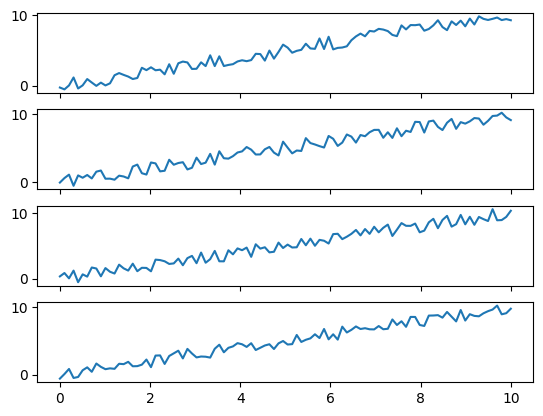

In [6]:
# визуализация созданных данных
fig, axs = plt.subplots(4, 1, sharex=True)

for i in range(4):
    xs, ys = read_dataset(f'data{i}')
    axs[i].plot(xs, ys)

In [7]:
# на случайном датасете (без искажения) обучаем модель
n = np.random.randint(0, 10)
xs, ys = read_dataset(f'data{n}')
model = LinearRegression().fit(xs, ys)

# теперь на каждом датасете (без искажений) посчитаем ошибку
# и выясним, насколько в среднем ошибаются модели
for i in range(10):
    xs, ys = read_dataset(f'data{i}')
    print(rmse(model.predict(xs), ys))

0.5952551647487606
0.62481474023656
0.6128978958753012
0.5434882697259489
0.5879732160171011
0.564878130132748
0.6295337701437093
0.6375800869803999
0.6215335771089524
0.57543296982409


Ошибка предсказания RMSE колеблется в диапазоне от 0,56 до 0,64. Предположим, что ошибка прогноза не должна превышать 1.

In [8]:
# сохраним модель
pkl_dump('model.pkl', model)

### Тестирование

Код для запуска тестов результатов предсказания модели ->

In [9]:
%%writefile test_performance.py
import pytest
import pickle
import numpy as np
from os import listdir
from sklearn.metrics import root_mean_squared_error as rmse


@pytest.fixture(scope='session')
def load_model():
    """
    фикстура для импорта модели. выполняется один раз за сеанс
    :return: модель
    """
    with open('model.pkl', 'rb') as file:
        model = pickle.load(file)
    return model


@pytest.fixture(scope='function')
def prediction(request, load_model):
    """
    фикстура для чтения файла и предсказания таргетов по фичам
    :param request: переменная от тестирующей функции (путь к файлу с данными)
    :param load_model: обращение к фикстуре загрузки модели
    :return: словарь. predicted - значения предсказаний модели, actual - истинные значения
    """
    model = load_model

    data = np.loadtxt(request.param, delimiter=',')
    x = data[:, 0].reshape(-1, 1)
    y = data[:, 1].reshape(-1, 1)

    y_hat = model.predict(x)

    return {'predicted': y_hat,
            'actual': y}


@pytest.mark.parametrize(
    "prediction",
    ['datasets/' + file for file in listdir('datasets')],
    indirect=True)
def test_performance(prediction):
    """
    функция тестирования результатов предсказания модели.
    успешное прохождение теста при RMSE меньше 1.
    параметризирована по файлам в директории datasets
    :param prediction: обращение к фикстуре prediction
    """
    assert rmse(prediction['predicted'], prediction['actual']) < 1

Overwriting test_performance.py


Запустим тестирование на имеющихся данных (без файла с искажениями)

In [10]:
! pytest -v test_performance.py

============================= test session starts =============================
platform win32 -- Python 3.12.7, pytest-8.3.5, pluggy-1.5.0 -- C:\Users\ilyazvlv\Documents\Python projects\mlops_practice\.venv\Scripts\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\ilyazvlv\Documents\Python projects\mlops_practice\lab5
plugins: anyio-4.9.0
collecting ... collected 10 items

test_performance.py::test_performance[datasets/data0.csv] PASSED         [ 10%]
test_performance.py::test_performance[datasets/data1.csv] PASSED         [ 20%]
test_performance.py::test_performance[datasets/data2.csv] PASSED         [ 30%]
test_performance.py::test_performance[datasets/data3.csv] PASSED         [ 40%]
test_performance.py::test_performance[datasets/data4.csv] PASSED         [ 50%]
test_performance.py::test_performance[datasets/data5.csv] PASSED         [ 60%]
test_performance.py::test_performance[datasets/data6.csv] PASSED         [ 70%]
test_performance.py::test_performance[datasets/data7.csv] PA

Тестирование прошло успешно.
Добавим в директорию datasets со всеми данными файл с искаженными данными и запустим тесты снова

In [11]:
# создадим датасет с искажениями
create_dataset('data100', noised=True)

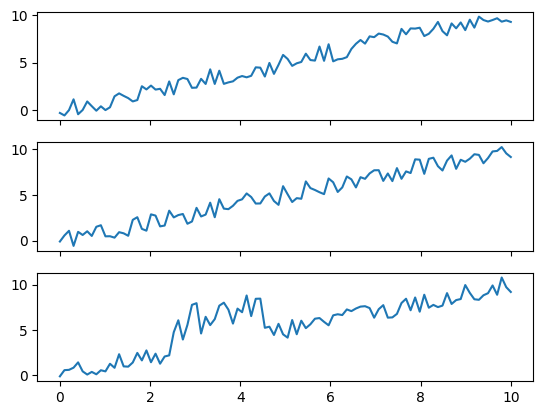

In [12]:
# посмотрим на него
fig, axs = plt.subplots(3, 1, sharex=True)
files = [0, 1, 100]

for i in files:
    xs, ys = read_dataset(f'data{i}')
    axs[files.index(i)].plot(xs, ys)

In [13]:
! pytest -v test_performance.py

============================= test session starts =============================
platform win32 -- Python 3.12.7, pytest-8.3.5, pluggy-1.5.0 -- C:\Users\ilyazvlv\Documents\Python projects\mlops_practice\.venv\Scripts\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\ilyazvlv\Documents\Python projects\mlops_practice\lab5
plugins: anyio-4.9.0
collecting ... collected 11 items

test_performance.py::test_performance[datasets/data0.csv] PASSED         [  9%]
test_performance.py::test_performance[datasets/data1.csv] PASSED         [ 18%]
test_performance.py::test_performance[datasets/data100.csv] FAILED       [ 27%]
test_performance.py::test_performance[datasets/data2.csv] PASSED         [ 36%]
test_performance.py::test_performance[datasets/data3.csv] PASSED         [ 45%]
test_performance.py::test_performance[datasets/data4.csv] PASSED         [ 54%]
test_performance.py::test_performance[datasets/data5.csv] PASSED         [ 63%]
test_performance.py::test_performance[datasets/data6.csv] PA

Тест упал на датасете с искажениями (data100). Остальные датасеты прошли тесты